In [140]:
import pathlib, random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

# Criando e analizando dataset

classe=tensor(2)


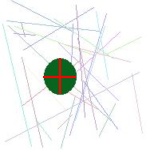

In [119]:
IMG_SIZE = 150

transformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1.), std=(2., 2., 2.)),
    transforms.ToPILImage()
])

class custom_dataset(Dataset):
    def __init__(self, df_):
        self.df_ = df_
        classes = self.df_['classe'].unique()
        self.classe2idx = {v:k for k, v in enumerate(classes)}
        self.idx2classe = {k:v for k, v in enumerate(classes)}
    
    def __getitem__(self, index):
        # img_path,img_w,img_h,xc/img_w,yc/img_h,w/img_w,h/img_h,classe
        img_path, imgw, imgh, xc, yc, w, h, classe = self.df_.values[index]
        img_pil = Image.open(img_path)
        return transformer(img_pil), torch.tensor([xc, yc, w, h]), torch.tensor(self.classe2idx[classe])

    def __len__(self):
        return len(self.df_)
    
    def desenha_amostra(self):
        img_tensor, bbox, classe = random.choice(self)
        img_pil = inv_transformer(img_tensor)
        draw = ImageDraw.Draw(img_pil)
        xc, yc, w, h = bbox
        xc, yc, w, h = xc*IMG_SIZE, yc*IMG_SIZE, w*IMG_SIZE, h*IMG_SIZE
        draw.line([xc, yc-h/2, xc, yc+h/2], fill='red', width=2)
        draw.line([xc-w/2, yc, xc+w/2, yc], fill='red', width=2)
        return img_pil, classe
        
df = pd.read_csv('annotations.csv')
dataset = custom_dataset(df)
img_tensor, bbox, classe = random.choice(dataset)
img_pil, classe = dataset.desenha_amostra()
print (f'{classe=}')
img_pil

In [120]:
img_tensor, bbox, classe = random.choice(dataset)
print (f'{img_tensor.shape=}, {bbox=}, {classe=}')

img_tensor.shape=torch.Size([3, 150, 150]), bbox=tensor([0.6828, 0.7809, 0.2203, 0.2360]), classe=tensor(2)


# Criando o modelo

In [116]:
class CustomModel(nn.Module):

    def __init__(self, input):
        super(CustomModel, self).__init__()

        self.backbone = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

        )

        output_backbone = self.backbone(input)
        _, c, x, y = output_backbone.shape
        in_features = c*x*y

        self.pbox = nn.Sequential(
            self.backbone,
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4, bias=True)
        )

        self.pclasse = nn.Sequential(
            self.backbone,
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=64, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=3),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        pred_bbox = self.pbox(x)
        pred_classe = self.pclasse(x)
        return pred_bbox, pred_classe

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
batch_imgs, batch_bbox, batch_target = next(iter(dataloader))

model = CustomModel(batch_imgs)
output = model(batch_imgs)
print (output)

(tensor([[-0.1851, -0.0508,  0.0088,  0.1070],
        [-0.1793,  0.0943, -0.2200,  0.4377]], grad_fn=<AddmmBackward>), tensor([[0.3160, 0.3487, 0.3353],
        [0.3375, 0.3064, 0.3561]], grad_fn=<SoftmaxBackward>))


# Preparando dados para treinamento

In [147]:
df = pd.read_csv('annotations.csv')
df = df.copy()[:50]
df_train, df_test = train_test_split(df, test_size=.1, shuffle=True, stratify=df['classe'])

train_dataset = custom_dataset(df_train)
test_dataset = custom_dataset(df_test)

print (f'{len(train_dataset)=}, {len(test_dataset)=}')

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print (f'{len(train_dataloader)=}, {len(test_dataloader)=}')

batch_tensor, batch_bbox, batch_target = next(iter(test_dataloader))
print (f'{batch_tensor.shape=}')

model = CustomModel(batch_tensor) # apenas iniciando o modelo

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

model.to(device)

criterion_bbox = nn.MSELoss()
criterion_target = nn.CrossEntropyLoss()

criterion_bbox.to(device)
criterion_target.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter(log_dir='./logs/treinamento-1')

len(train_dataset)=45, len(test_dataset)=5
len(train_dataloader)=2, len(test_dataloader)=1
batch_tensor.shape=torch.Size([5, 3, 150, 150])
device=device(type='cpu')


# Funções uteis

In [148]:
def validar(dataloader_):
    model.eval()
    clear_output(wait=True)
    print ('validação')
    with torch.no_grad():
        bbox_loss, target_loss, n = 0, 0, 0
        for batch_tensor, batch_bbox, batch_target in tqdm(dataloader_, ncols=50):
            batch_tensor, batch_bbox, batch_target = batch_tensor.to(device), batch_bbox.to(device), batch_target.to(device)
            pred_bbox, pred_target = model(batch_tensor)
            loss_bbox = criterion_bbox(pred_bbox, batch_bbox)
            loss_target = criterion_target(pred_target, batch_target)

            n += len(batch_tensor)

            bbox_loss += loss_bbox.item()
            target_loss += loss_target.item()
    
    return bbox_loss/n, target_loss/n

validar(test_dataloader)

validação


100%|███████████████| 1/1 [00:00<00:00,  2.23it/s]


(0.037843286991119385, 0.21917381286621093)

# Treinamento

In [149]:
for epoch in range(2):

    model.train()
    clear_output(wait=True)
    print (f'{epoch=}')

    bbox_train_loss, target_train_loss, n = 0, 0, 0
    for batch_tensor, batch_bbox, batch_target in tqdm(train_dataloader, ncols=50):
        batch_tensor, batch_bbox, batch_target = batch_tensor.to(device), batch_bbox.to(device), batch_target.to(device)

        model.zero_grad()

        pred_bbox, pred_target = model(batch_tensor)
        loss_bbox = criterion_bbox(pred_bbox, batch_bbox)
        loss_target = criterion_target(pred_target, batch_target)

        loss_bbox.backward()
        loss_target.backward()

        optimizer.step()

        bbox_train_loss += loss_bbox.item()
        target_train_loss += loss_target.item()
        n += len(batch_tensor)
    
    bbox_train_loss, target_train_loss = bbox_train_loss/n, target_train_loss/n
    
    bbox_test_loss, target_test_loss = validar(test_dataloader)

    writer.add_scalar('bbox_train_loss', bbox_train_loss, epoch)
    writer.add_scalar('target_train_loss', target_train_loss, epoch)
    writer.add_scalar('bbox_test_loss', bbox_test_loss, epoch)
    writer.add_scalar('target_test_loss', target_test_loss, epoch)

validação


100%|███████████████| 1/1 [00:00<00:00,  2.38it/s]
